In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time
import xgboost as xgb

# Dataset

In [2]:
data = 'https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv'

In [3]:
!wget $data data-week-6.csv

--2025-09-25 23:40:31--  https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv [following]
--2025-09-25 23:40:31--  https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391501 (382K) [text/plain]
Saving to: ‘jamb_exam_results.csv’

jamb_exam_results.c 100%[===================>] 382.33K  --.-KB/s    in 0.03s   

2025-09-25 23:40:31 (14.3 MB/s) - ‘jamb_exam_result

In [4]:
df = pd.read_csv('jamb_exam_results.csv')

In [5]:
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


# Preparing the dataset

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [7]:
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [8]:
del df['student_id']

In [9]:
df.isnull().sum()

jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64

In [10]:
df['parent_education_level'] = df['parent_education_level'].fillna(0)

In [11]:
df_full_train, df_test = train_test_split(df, random_state=1, test_size=0.2)

In [12]:
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [13]:
len(df), len(df_train), len(df_val), len(df_test)

(5000, 3000, 1000, 1000)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [16]:
dv = DictVectorizer(sparse=True)

In [17]:
train_dict = df_train.to_dict(orient='records')

In [18]:
X_train = dv.fit_transform(train_dict)

In [19]:
dv.get_feature_names_out()

array(['access_to_learning_materials=No',
       'access_to_learning_materials=Yes', 'age', 'assignments_completed',
       'attendance_rate', 'distance_to_school', 'extra_tutorials=No',
       'extra_tutorials=Yes', 'gender=Female', 'gender=Male',
       'it_knowledge=High', 'it_knowledge=Low', 'it_knowledge=Medium',
       'parent_education_level', 'parent_education_level=Primary',
       'parent_education_level=Secondary',
       'parent_education_level=Tertiary', 'parent_involvement=High',
       'parent_involvement=Low', 'parent_involvement=Medium',
       'school_location=Rural', 'school_location=Urban',
       'school_type=Private', 'school_type=Public',
       'socioeconomic_status=High', 'socioeconomic_status=Low',
       'socioeconomic_status=Medium', 'study_hours_per_week',
       'teacher_quality'], dtype=object)

In [20]:
val_dict = df_val.to_dict(orient='records')

In [21]:
X_val = dv.transform(val_dict)

# Question 1

In [22]:
dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [23]:
y_pred = dt.predict(X_val)

In [24]:
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
rmse

np.float64(45.80335905740839)

In [25]:
names = dv.get_feature_names_out().tolist()
print(export_text(dt, feature_names=names))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



# Question 2

In [26]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [27]:
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [28]:
y_pred = rf.predict(X_val)

In [29]:
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
rmse

np.float64(42.13724207871227)

# Question 3

In [30]:
scores = []

In [31]:
for n in range(10, 201, 10):
    start = time.time()
    
    rf = RandomForestRegressor(n_estimators=n
                               , random_state=1
                               , n_jobs=-1)
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    
    mse = mean_squared_error(y_val, y_pred)
    
    rmse = np.sqrt(mse)
    
    elapsed = time.time() - start
    
    scores.append((n, rmse))
    
    print("RMSE: %.4f, Time Elapsed: %.2f sec" % (rmse, elapsed))

RMSE: 42.1372, Time Elapsed: 0.64 sec
RMSE: 41.4612, Time Elapsed: 1.13 sec
RMSE: 41.1062, Time Elapsed: 1.67 sec
RMSE: 40.9172, Time Elapsed: 2.11 sec
RMSE: 40.8523, Time Elapsed: 2.73 sec
RMSE: 40.7843, Time Elapsed: 3.34 sec
RMSE: 40.6771, Time Elapsed: 3.74 sec
RMSE: 40.5393, Time Elapsed: 4.43 sec
RMSE: 40.5043, Time Elapsed: 4.85 sec
RMSE: 40.5168, Time Elapsed: 5.52 sec
RMSE: 40.5934, Time Elapsed: 5.83 sec
RMSE: 40.6249, Time Elapsed: 6.48 sec
RMSE: 40.6508, Time Elapsed: 7.01 sec
RMSE: 40.5949, Time Elapsed: 7.67 sec
RMSE: 40.5967, Time Elapsed: 8.11 sec
RMSE: 40.6035, Time Elapsed: 8.61 sec
RMSE: 40.6275, Time Elapsed: 9.18 sec
RMSE: 40.6413, Time Elapsed: 9.75 sec
RMSE: 40.6314, Time Elapsed: 10.31 sec
RMSE: 40.6010, Time Elapsed: 10.88 sec


In [32]:
columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [33]:
df_scores

,n_estimators,rmse
0,10,42.137242
1,20,41.461215
2,30,41.106171
3,40,40.917194
4,50,40.852279
5,60,40.784281
6,70,40.677098
7,80,40.539333
8,90,40.504346
9,100,40.516805


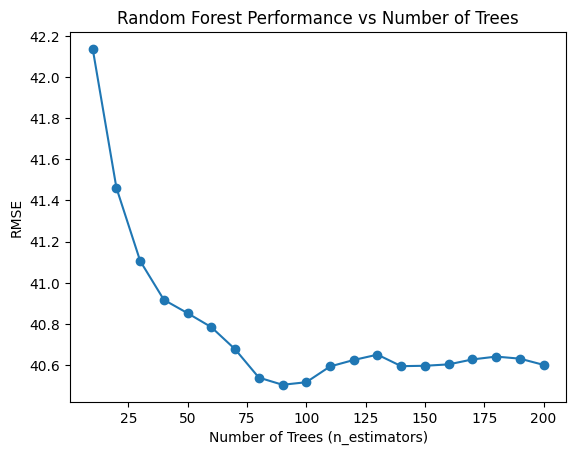

In [34]:
plt.plot(df_scores['n_estimators'], df_scores['rmse'], marker="o")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("RMSE")
plt.title("Random Forest Performance vs Number of Trees")
plt.show()

# Question 4

In [35]:
scores = []
 
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        start = time.time()
    
        rf = RandomForestRegressor(n_estimators=n
                               , max_depth=d
                               , random_state=1
                               , n_jobs=-1)
        rf.fit(X_train, y_train)
 
        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
    
        rmse = np.sqrt(mse)
        
        elapsed = time.time() - start
         
        scores.append((d, n, rmse))
        print("D: %d, N: %d, RMSE: %.4f, Time Elapsed: %.2f sec" % (d, n, rmse, elapsed))
 
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

D: 10, N: 10, RMSE: 41.2583, Time Elapsed: 0.29 sec
D: 10, N: 20, RMSE: 40.8805, Time Elapsed: 0.53 sec
D: 10, N: 30, RMSE: 40.6250, Time Elapsed: 0.84 sec
D: 10, N: 40, RMSE: 40.2701, Time Elapsed: 1.05 sec
D: 10, N: 50, RMSE: 40.3170, Time Elapsed: 1.38 sec
D: 10, N: 60, RMSE: 40.2770, Time Elapsed: 1.59 sec
D: 10, N: 70, RMSE: 40.2852, Time Elapsed: 1.92 sec
D: 10, N: 80, RMSE: 40.2103, Time Elapsed: 2.35 sec
D: 10, N: 90, RMSE: 40.1739, Time Elapsed: 2.43 sec
D: 10, N: 100, RMSE: 40.2505, Time Elapsed: 2.64 sec
D: 10, N: 110, RMSE: 40.2863, Time Elapsed: 3.02 sec
D: 10, N: 120, RMSE: 40.3153, Time Elapsed: 3.37 sec
D: 10, N: 130, RMSE: 40.3290, Time Elapsed: 3.45 sec
D: 10, N: 140, RMSE: 40.2998, Time Elapsed: 3.76 sec
D: 10, N: 150, RMSE: 40.3143, Time Elapsed: 4.24 sec
D: 10, N: 160, RMSE: 40.3544, Time Elapsed: 4.24 sec
D: 10, N: 170, RMSE: 40.3601, Time Elapsed: 4.71 sec
D: 10, N: 180, RMSE: 40.3642, Time Elapsed: 4.88 sec
D: 10, N: 190, RMSE: 40.3538, Time Elapsed: 5.19 sec
D:

,max_depth,n_estimators,rmse
0,10,10,41.258349
1,10,20,40.880528
2,10,30,40.624956
3,10,40,40.270069
4,10,50,40.317006


In [36]:
mean_rmse_per_depth = df_scores.groupby("max_depth")["rmse"].mean()
print(mean_rmse_per_depth)

max_depth
10    40.392498
15    40.735282
20    40.739734
25    40.787866
Name: rmse, dtype: float64


# Question 5

In [37]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [38]:
df_importances = pd.DataFrame({
    "feature": names,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

df_importances

,feature,importance
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311
3,assignments_completed,0.031517
24,socioeconomic_status=High,0.025714
17,parent_involvement=High,0.022919
10,it_knowledge=High,0.017719
15,parent_education_level=Secondary,0.016957


# Question 6

In [39]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [40]:
for e in [0.1, 0.3]:
    xgb_params = {
        'eta': e, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }

    watchlist = [(dtrain, 'train'), (dval, 'val')]
    
    model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

    y_pred = model.predict(dval)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    print()
    print("ETA: %.1f, RMSE: %.4f" % (e, rmse))
    print()

[0]	train-rmse:45.49999	val-rmse:47.00533
[1]	train-rmse:44.12948	val-rmse:45.92344
[2]	train-rmse:42.94858	val-rmse:44.98366
[3]	train-rmse:41.90896	val-rmse:44.25755
[4]	train-rmse:40.96728	val-rmse:43.57339
[5]	train-rmse:40.17514	val-rmse:43.11181
[6]	train-rmse:39.40436	val-rmse:42.61054
[7]	train-rmse:38.71199	val-rmse:42.18883
[8]	train-rmse:38.08081	val-rmse:41.86754
[9]	train-rmse:37.57559	val-rmse:41.64338
[10]	train-rmse:37.07490	val-rmse:41.39235
[11]	train-rmse:36.58709	val-rmse:41.14265
[12]	train-rmse:36.14574	val-rmse:40.95201
[13]	train-rmse:35.76896	val-rmse:40.81778
[14]	train-rmse:35.40802	val-rmse:40.75008
[15]	train-rmse:35.08521	val-rmse:40.61341
[16]	train-rmse:34.74187	val-rmse:40.51800
[17]	train-rmse:34.43969	val-rmse:40.41659
[18]	train-rmse:34.16132	val-rmse:40.33546
[19]	train-rmse:33.91836	val-rmse:40.25632
[20]	train-rmse:33.67389	val-rmse:40.25010
[21]	train-rmse:33.45853	val-rmse:40.19826
[22]	train-rmse:33.23371	val-rmse:40.21101
[23]	train-rmse:32.98